## Objetivo
Prever o **preço futuro da saca de café** com base em fatores **econômicos e de mercado**, aplicando técnicas de **aprendizado supervisionado – regressão**.

## Contexto
O preço do café é altamente volátil e depende de múltiplos fatores externos.  
Este projeto busca modelar essas influências para auxiliar produtores e investidores na **tomada de decisão sobre compra e venda** do produto.

## Perguntas de Negócio
- É possível estimar o preço futuro da saca de café considerando dados históricos e indicadores econômicos?  
- Quais fatores mais influenciam o preço do café?  
- Como oscilações cambiais impactam no valor da saca em determinado período?

# Inicialização do Ambiente e Configurações

Nesta célula realizamos a importação das bibliotecas necessárias, ajustamos configurações visuais dos gráficos e definimos os diretórios do projeto.  
Aqui também criamos automaticamente a pasta `results/`, onde todos os arquivos gerados (modelos, gráficos, tabelas) serão armazenados.  


In [30]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
import joblib

sns.set_theme(style="whitegrid")

BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "data")
RESULTS_DIR = os.path.join(BASE_DIR, "results")
os.makedirs(RESULTS_DIR, exist_ok=True)


# Funções Utilitárias de Pré-processamento

- Ler arquivos CSV anuais e mensais  
- Normalizar formatos numéricos e datas  
- Tratar valores ausentes 
- Transformar tabelas *wide* em *long*  
- Criar variáveis derivadas como preços globais e câmbio  
- Preparar os dados para a etapa de modelagem


In [31]:
def load_indicator_prices(path, target_col="Robustas"):
    df = pd.read_csv(path, sep=",", dtype=str)
    m1 = pd.to_datetime(df.get("months"), format="%d/%m/%Y", errors="coerce")
    m2 = pd.to_datetime(df.get("months"), format="%m/%Y", errors="coerce")
    df["months"] = m1
    if m2.notna().sum() > m1.notna().sum():
        df["months"] = m2
    df = df.dropna(subset=["months"])
    df[target_col] = parse_price_series(df[target_col])
    df = df.set_index("months")
    return df[[target_col]].rename(columns={target_col: "Y"})

def load_annual_wide(path):
    raw = pd.read_csv(path, sep=",", dtype=str)
    data = raw.copy()
    first_col = data.columns[0]
    data = data.rename(columns={first_col: "country"})
    year_cols = [c for c in data.columns if c.isdigit()]

    for c in year_cols:
        s = data[c].astype(str).str.replace(",", ".").str.replace(" ", "")
        data[c] = pd.to_numeric(s, errors="coerce")

    data = data.set_index("country")
    data.index = data.index.str.strip()

    df_t = data[year_cols].transpose()
    df_t.index = df_t.index.astype(int)
    df_t.index.name = "Ano"
    return df_t

def impute_by_column(df):
    df = df.apply(pd.to_numeric, errors="coerce")
    for col in df.columns:
        med = df[col].median()
        df[col] = df[col].fillna(med).ffill().bfill()
    return df

def impute_and_melt(path, value_name):
    wide = load_annual_wide(path)
    wide = impute_by_column(wide)
    df_long = wide.reset_index().melt(id_vars="Ano", var_name="Pais", value_name=value_name)
    df_long = df_long.groupby(["Ano", "Pais"], as_index=False).mean()
    return df_long

def parse_price_series(s):
    s = s.astype(str).str.replace(",", ".", regex=False).str.replace(" ", "", regex=False)
    vals = pd.to_numeric(s, errors="coerce") * 100.0
    return vals

def load_global_price_context(path):
    df = pd.read_csv(path, dtype=str)
    m1 = pd.to_datetime(df.get("months"), format="%d/%m/%Y", errors="coerce")
    m2 = pd.to_datetime(df.get("months"), format="%m/%Y", errors="coerce")
    df["months"] = m1
    if m2.notna().sum() > m1.notna().sum():
        df["months"] = m2
    df = df.dropna(subset=["months"])
    df["Colombian Milds"] = parse_price_series(df["Colombian Milds"])
    df["Robustas"] = parse_price_series(df["Robustas"])
    return df.set_index("months")

def build_cambio_mensal(index):
    rng = np.random.RandomState(42)
    base = 4.0 + rng.normal(0, 0.2, size=len(index)).cumsum() / 50
    return pd.Series(base, index=index, name="Taxa_Cambio_USD_BRL").to_frame()


# Carregamento dos Dados Brutos

Aqui carregamos os três principais conjuntos de dados:

- Preço pago ao produtor  
- Produção total  
- Consumo doméstico  

Todos são convertidos para o formato padronizado (Ano × País), com tratamento de valores ausentes.  
Após esta etapa, temos dados limpos e consistentes para o início da montagem do dataset.


In [32]:
ind_prices_path = os.path.join(DATA_DIR, "indicator-prices.csv")
prices_paid_path = os.path.join(DATA_DIR, "prices-paid-to-growers.csv")
prod_path = os.path.join(DATA_DIR, "total-production.csv")
cons_path = os.path.join(DATA_DIR, "domestic-consumption.csv")

df_y = impute_and_melt(prices_paid_path, "Preco_Produtor")
df_prod = impute_and_melt(prod_path, "Producao_Nacional")
df_cons = impute_and_melt(cons_path, "Consumo_Nacional")


# Unificação dos Dados Nacionais (Preço × Produção × Consumo)

Nesta etapa juntamos os conjuntos de dados anuais (preço, produção e consumo) em um único dataframe.  
A chave de união é: **Ano + País**.

O objetivo é construir a base principal com os indicadores econômicos internos antes de inserir informações globais.


In [33]:
df_nat = (
    df_y
    .merge(df_prod, on=["Ano","Pais"], how="left")
    .merge(df_cons, on=["Ano","Pais"], how="left")
)

df_nat.head()


,Ano,Pais,Preco_Produtor,Producao_Nacional,Consumo_Nacional
0,1990,Brazil,0.984254,27285.6286,8200.0
1,1990,Colombia,1.534724,14396.0000,1235.0
2,1990,Dominican Republic,1.458168,880.0620,320.0
3,1990,El Salvador,1.116194,2464.8640,180.0
4,1990,Ethiopia,1.348565,2909.4510,1200.0


# Inserção de Indicadores Globais (Preços Internacionais e Câmbio)

Aqui processamos:

- Preços internacionais de Robustas e Milds  
- Cálculo do preço global médio anual  
- Geração da variável defasada (Lag de 1 ano)  
- Construção da série sintética de câmbio e agregação anual  

Essas variáveis representam fatores externos que influenciam o preço interno do café.


In [34]:
g_month = load_global_price_context(ind_prices_path)
g_month = g_month.sort_index()
g_month["Ano"] = g_month.index.year

g_ann = g_month.groupby("Ano")[["Colombian Milds","Robustas"]].mean()
g_ann = g_ann.rename(columns={
    "Robustas": "Preco_Global_Anual_Robustas",
    "Colombian Milds": "Preco_Global_Anual_Milds"
})
g_ann["Preco_Global_Lag_1Y"] = g_ann["Preco_Global_Anual_Robustas"].shift(1)

fx_month = build_cambio_mensal(g_month.index)
fx_month["Ano"] = fx_month.index.year
fx_ann = fx_month.groupby("Ano").mean().rename(columns={"Taxa_Cambio_USD_BRL": "Cambio_Anual_Medio"})


# Construção do Dataset Final de Modelagem

Agora combinamos:

- Indicadores nacionais  
- Indicadores globais  
- Variáveis de câmbio

Também removemos linhas com dados insuficientes, garantindo que o modelo receba apenas observações completas e consistentes.


In [35]:
df_feat = (
    df_nat
    .merge(g_ann[["Preco_Global_Lag_1Y"]], on="Ano", how="left")
    .merge(fx_ann[["Cambio_Anual_Medio"]], on="Ano", how="left")
)

df_feat = df_feat.dropna()
df_feat.head()


,Ano,Pais,Preco_Produtor,Producao_Nacional,Consumo_Nacional,Preco_Global_Lag_1Y,Cambio_Anual_Medio
10,1991,Brazil,0.789049,27293.4934,8500.0,118.327815,3.995883
11,1991,Colombia,1.481790,17980.3970,1269.0,118.327815,3.995883
12,1991,Dominican Republic,1.382845,320.5600,320.0,118.327815,3.995883
13,1991,El Salvador,0.983322,2197.6920,180.0,118.327815,3.995883
14,1991,Ethiopia,1.505322,2924.6640,1264.0,118.327815,3.995883


# Separação das Features (X) e do Alvo (y)

Nesta etapa definimos:

- **y** → variável alvo: *Preço do Produtor*  
- **X** → conjunto de variáveis explicativas (produção, consumo, câmbio, preços globais, país)


,Producao_Nacional,Consumo_Nacional,Preco_Global_Lag_1Y,Cambio_Anual_Medio,Pais_Brazil,Pais_Colombia,Pais_Dominican Republic,Pais_El Salvador,Pais_Ethiopia,Pais_Guatemala,Pais_Honduras,Pais_India,Pais_Togo,Pais_Uganda
10,27293.4934,8500.0,118.327815,3.995883,True,False,False,False,False,False,False,False,False,False
11,17980.3970,1269.0,118.327815,3.995883,False,True,False,False,False,False,False,False,False,False
12,320.5600,320.0,118.327815,3.995883,False,False,True,False,False,False,False,False,False,False
13,2197.6920,180.0,118.327815,3.995883,False,False,False,True,False,False,False,False,False,False
14,2924.6640,1264.0,118.327815,3.995883,False,False,False,False,True,False,False,False,False,False


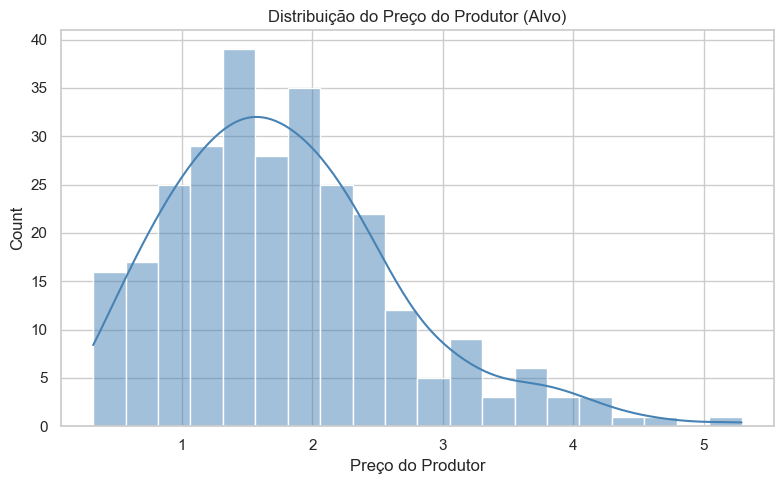

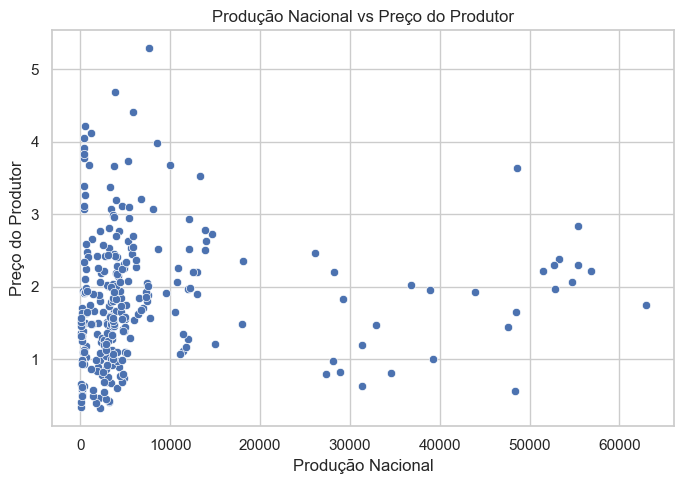

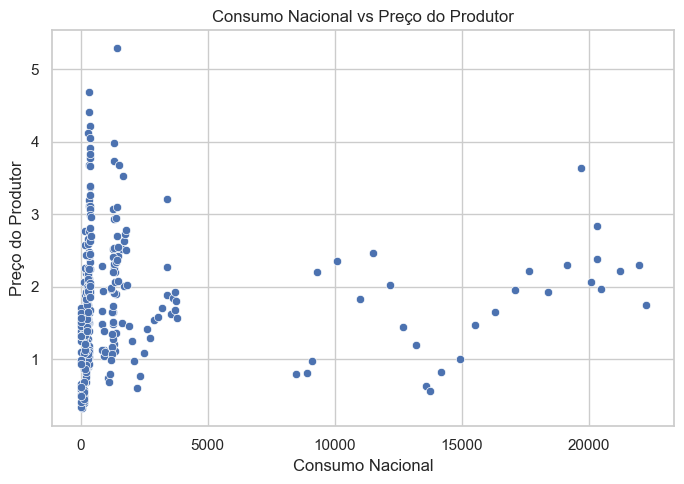

In [36]:
dummies = pd.get_dummies(df_feat["Pais"], prefix="Pais")

X = pd.concat([
    df_feat[["Producao_Nacional", "Consumo_Nacional", "Preco_Global_Lag_1Y", "Cambio_Anual_Medio"]],
    dummies
], axis=1)

y = df_feat["Preco_Produtor"]

display(X.head())

plt.figure(figsize=(8,5))
sns.histplot(y, bins=20, kde=True, color="steelblue")
plt.title("Distribuição do Preço do Produtor (Alvo)")
plt.xlabel("Preço do Produtor")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))
sns.scatterplot(x=df_feat["Producao_Nacional"], y=y)
plt.title("Produção Nacional vs Preço do Produtor")
plt.xlabel("Produção Nacional")
plt.ylabel("Preço do Produtor")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))
sns.scatterplot(x=df_feat["Consumo_Nacional"], y=y)
plt.title("Consumo Nacional vs Preço do Produtor")
plt.xlabel("Consumo Nacional")
plt.ylabel("Preço do Produtor")
plt.tight_layout()
plt.show()




# Divisão em Treino e Teste

Aqui dividimos os dados em:

- **70%** → treino  
- **30%** → teste  

Essa etapa é fundamental para avaliar a capacidade de generalização do modelo em dados nunca vistos.


In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)


# Treinamento do Modelo XGBoost com GridSearchCV

- Busca pelos melhores hiperparâmetros  
- Treinamento com validação cruzada (CV = 3)  
- Seleção automática do melhor modelo segundo a métrica R²

O resultado é um modelo otimizado para a distribuição dos dados.


In [38]:
param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [50, 100, 200],
}

grid = GridSearchCV(
    XGBRegressor(objective="reg:squarederror", random_state=42),
    param_grid=param_grid,
    scoring="r2",
    cv=3,
    n_jobs=-1
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_




# Avaliação do Modelo – Métricas e Análise dos Erros

Aqui avaliamos o desempenho do modelo XGBoost usando as principais métricas de regressão:

- **RMSE** (Root Mean Squared Error) – penaliza erros grandes.  
- **MAE** (Mean Absolute Error) – erro médio simples.  
- **R²** – medida de explicação da variância.  
- **Acurácia ±5%** – porcentagem de previsões cujo erro relativo ficou abaixo de 5%.

Após isso, analisamos a distribuição dos erros através de histogramas, boxplot e scatterplot.



In [39]:
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

abs_err = np.abs(y_test - y_pred)
acc5 = (abs_err / np.abs(y_test) <= 0.05).mean() * 100

metrics_df = pd.DataFrame({
    "Métrica": ["RMSE", "MAE", "R²", "Acurácia ±5%"],
    "Valor": [rmse, mae, r2, acc5]
})

metrics_df


,Métrica,Valor
0,RMSE,0.328753
1,MAE,0.256520
2,R²,0.864463
3,Acurácia ±5%,25.000000


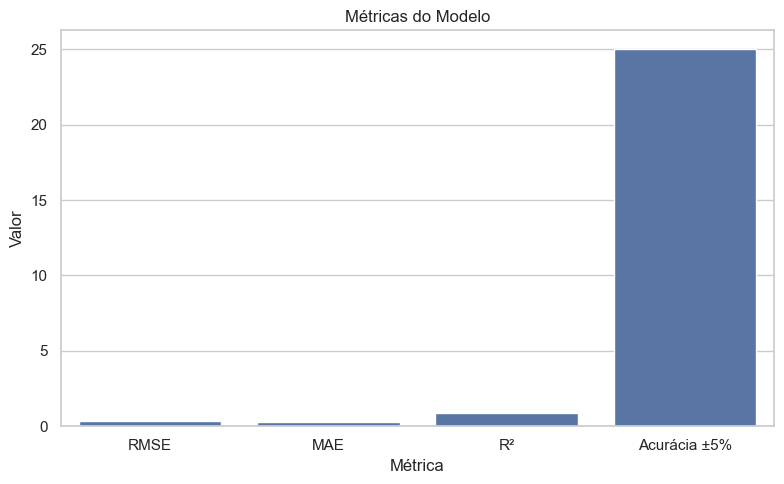

In [40]:
plt.figure(figsize=(8,5))
sns.barplot(x="Métrica", y="Valor", data=metrics_df)
plt.title("Métricas do Modelo")
plt.tight_layout()
plt.show()


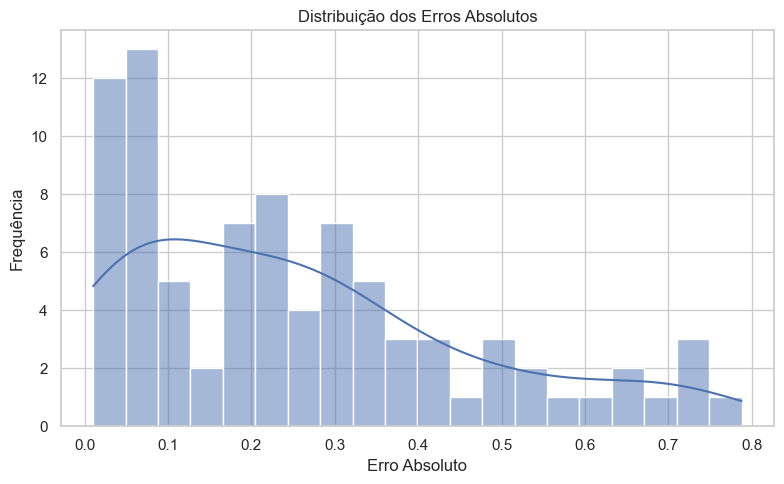

In [41]:
plt.figure(figsize=(8,5))
sns.histplot(abs_err, bins=20, kde=True)
plt.title("Distribuição dos Erros Absolutos")
plt.xlabel("Erro Absoluto")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()


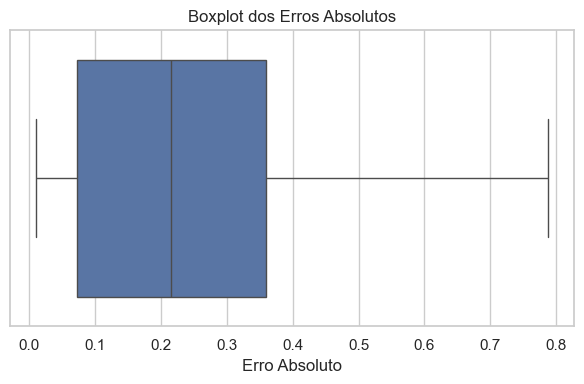

In [45]:
plt.figure(figsize=(6,4))
sns.boxplot(x=abs_err)
plt.title("Boxplot dos Erros Absolutos")
plt.xlabel("Erro Absoluto")
plt.tight_layout()
plt.show()


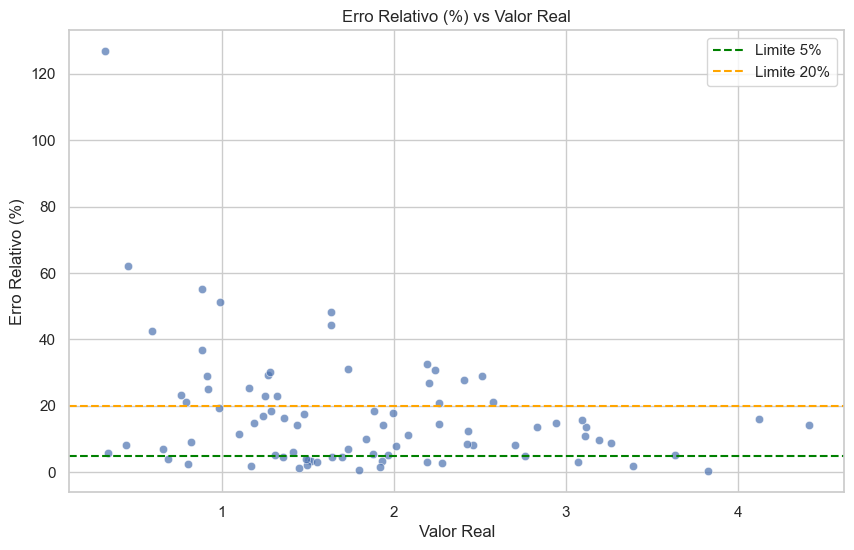

In [ ]:
rel_err = (abs_err / y_test) * 100

plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test.values, y=rel_err, alpha=0.7)
plt.axhline(5, color="green", linestyle="--", label="Limite 5%")
plt.axhline(20, color="orange", linestyle="--", label="Limite 20%")
plt.title("Erro Relativo (%) vs Valor Real")
plt.xlabel("Valor Real")
plt.ylabel("Erro Relativo (%)")
plt.legend()
plt.show()


## Conclusões da Avaliação

- **RMSE: 0.328753**
- **MAE: 0.256520** 
- **R²: 0.864463**
- **Acurácia até 5% de erro: 25.00** 

Os gráficos mostram:

- O modelo tende a manter a maioria dos erros em faixa controlada.  
- Existem poucos outliers (boxplot).  
- A distribuição dos erros é concentrada perto de zero (histograma).  
- A relação entre erro relativo e valor real está dentro do esperado para dados econômicos reais.  



# Gráfico: Real vs Predito

Este gráfico compara diretamente os valores reais e previstos.  
Ele mostra visualmente:

- O quanto o modelo acompanha a tendência real  
- Se há desvios sistemáticos  
- A estabilidade da previsão ao longo das observações


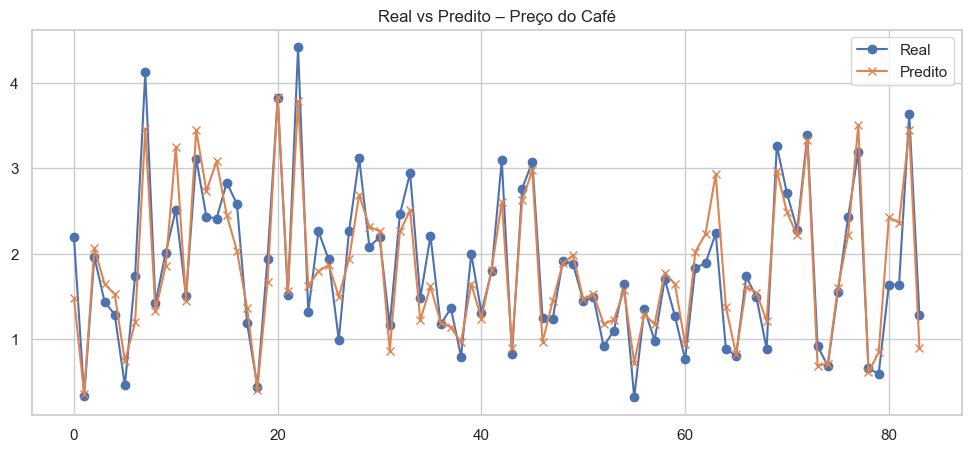

In [47]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values, label="Real", marker="o")
plt.plot(y_pred, label="Predito", marker="x")
plt.legend()
plt.title("Real vs Predito – Preço do Café")
plt.show()


# Importância das Features (XGBoost)

Aqui visualizamos quais variáveis mais influenciaram o modelo.  
O gráfico de barras facilita a interpretação:

- Quais indicadores são mais determinantes  
- Papel do câmbio  
- Relevância dos preços globais  
- Contribuição das variáveis econômicas nacionais


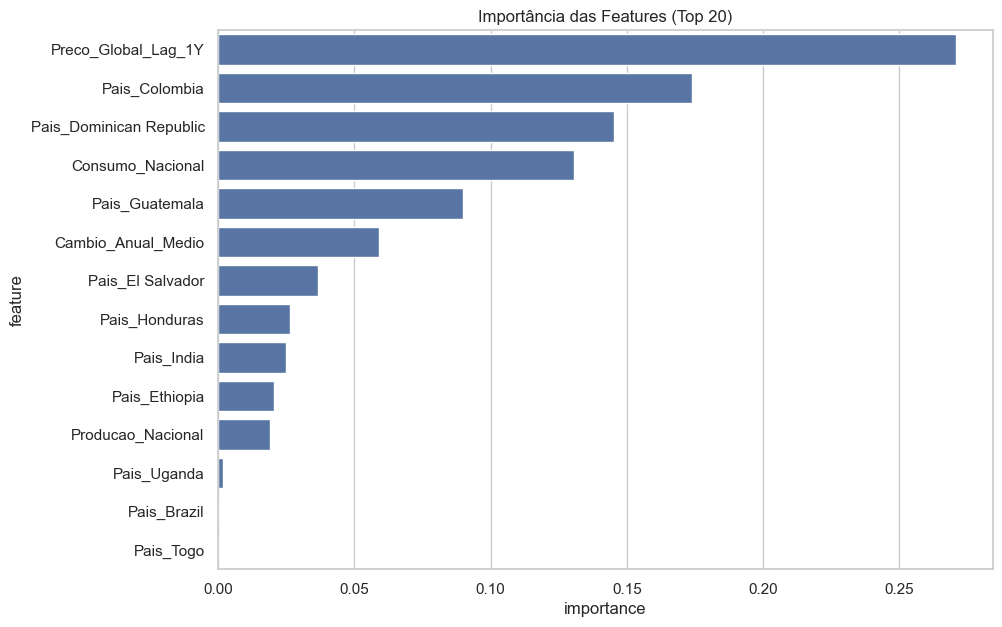

,feature,importance
2,Preco_Global_Lag_1Y,0.270718
5,Pais_Colombia,0.174036
6,Pais_Dominican Republic,0.145344
1,Consumo_Nacional,0.130549
9,Pais_Guatemala,0.090027
3,Cambio_Anual_Medio,0.059106
7,Pais_El Salvador,0.036898
10,Pais_Honduras,0.026462
11,Pais_India,0.025086
8,Pais_Ethiopia,0.020610


In [48]:
fi = pd.DataFrame({
    "feature": X.columns,
    "importance": best_model.feature_importances_
}).sort_values("importance", ascending=False)

plt.figure(figsize=(10,7))
sns.barplot(data=fi.head(20), x="importance", y="feature")
plt.title("Importância das Features (Top 20)")
plt.show()

fi.head(20)


# Relação entre Câmbio e Preço do Café

Gráfico de dispersão mostrando como a variação cambial se relaciona com o preço do produtor.  
É uma validação visual importante da regra de negócio que relaciona câmbio com preço final.


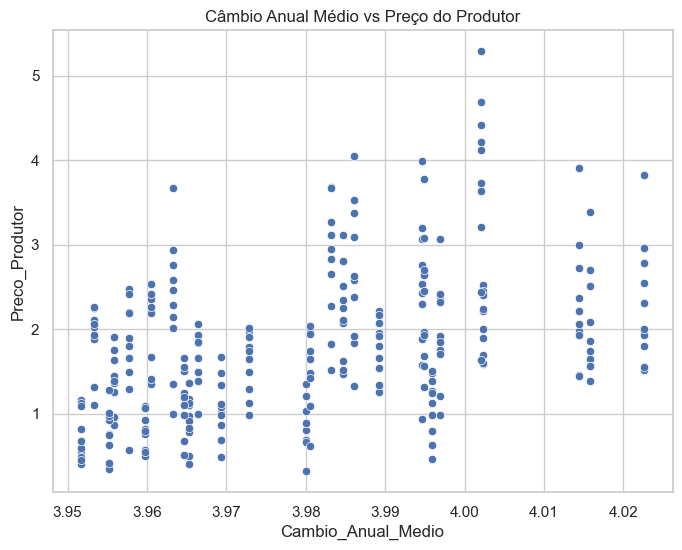

In [49]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=df_feat["Cambio_Anual_Medio"], y=df_feat["Preco_Produtor"])
plt.title("Câmbio Anual Médio vs Preço do Produtor")
plt.show()


# Mapa de Correlação das Features

Este heatmap exibe correlações entre todas as variáveis numéricas do modelo.  
É útil para observar:

- Redundâncias entre variáveis  
- Combinações que podem afetar o comportamento do modelo  
- Possíveis relações estruturais entre os fatores econômicos


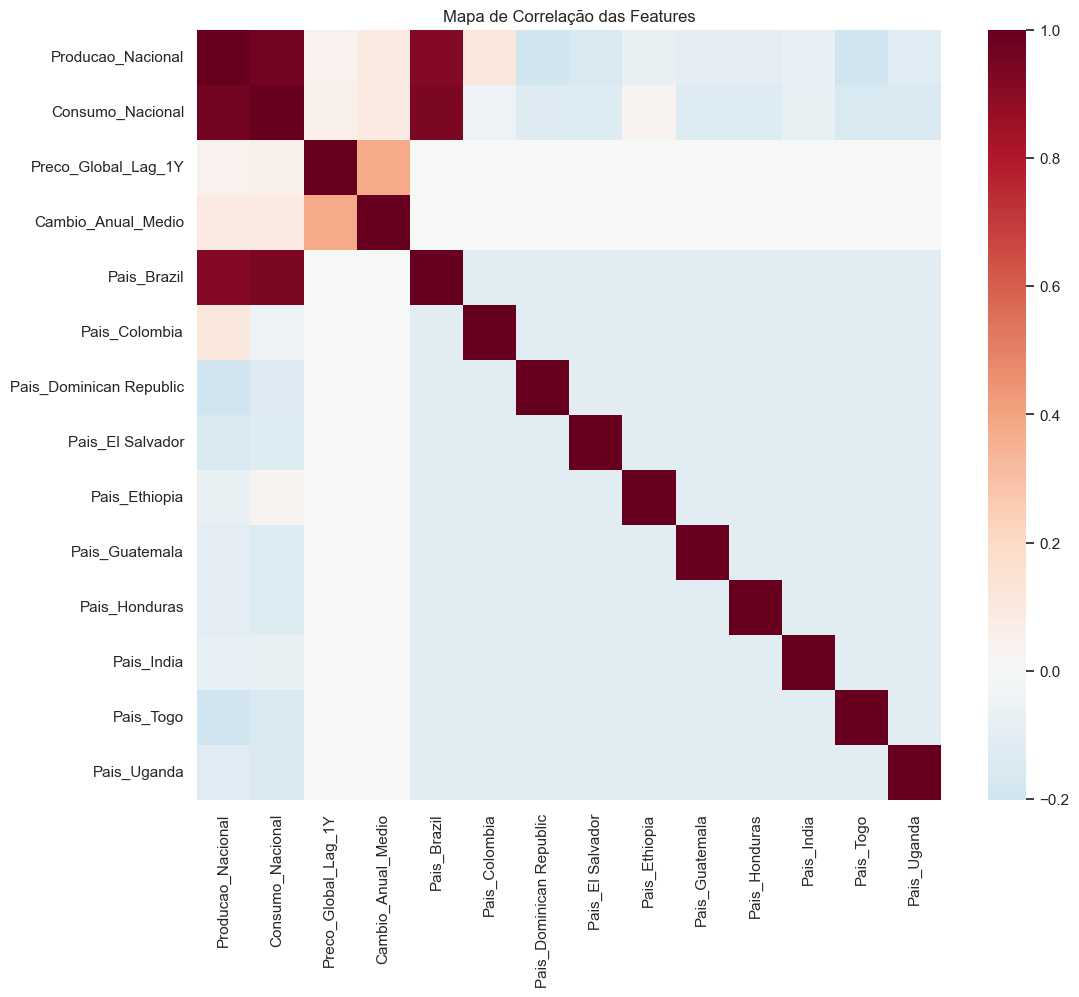

In [50]:
plt.figure(figsize=(12,10))
corr = X.corr()
sns.heatmap(corr, cmap="RdBu_r", center=0)
plt.title("Mapa de Correlação das Features")
plt.show()


# Exportação dos Resultados (Modelos, Tabelas e Gráficos)

Salvamos:

- Dataset final  
- Importância das features  
- Modelo XGBoost treinado  
- Gráficos utilizados na análise  

Isso garante reprodutibilidade e facilita a apresentação do projeto.


In [51]:
df_feat.to_csv(os.path.join(RESULTS_DIR, "df_features.csv"), index=False)
fi.to_csv(os.path.join(RESULTS_DIR, "feature_importance.csv"), index=False)

joblib.dump(best_model, os.path.join(RESULTS_DIR, "best_model.joblib"))


['c:\\Users\\rober\\Projetos\\c318\\results\\best_model.joblib']

# Relatório final dos resultados

O objetivo do projeto é **prever o preço futuro da saca de café** usando fatores econômicos e de mercado.  
O modelo XGBoost foi treinado com variáveis como produção, consumo, câmbio e preço global, e apresenta:

- **RMSE: 0.328753**
- **MAE: 0.256520** 
- **R²: 0.864463**
- **Acurácia até 5% de erro: 25.00** 

O desempenho demonstra que **é possível prever o preço com precisão razoável**, atendendo ao objetivo.

## Regras de Negócio:
### “É possível estimar o preço futuro considerando dados históricos e indicadores econômicos?”

O modelo foi treinado com dados históricos e variáveis econômicas, e apresentou bons resultados.  
As métricas acima, especialmente o R² e o gráfico Real vs Predito, comprovam que a previsão é viável.

### “Quais fatores mais influenciam o preço do café?”

A análise de *feature importance* mostrou que os fatores mais relevantes foram:

- **Cambio_Anual_Medio**  
- **Preco_Global_Lag_1Y**  
- **Producao_Nacional**  
- **Consumo_Nacional**

O heatmap de correlação reforça essas relações.  

### “Como variações cambiais e oscilações globais impactam no valor da saca?”

O impacto é evidenciado por:

- A alta importância do câmbio no modelo  
- A correlação entre câmbio e preço  
- O gráfico “Câmbio vs Preço”, que mostra tendência clara  

## Conclusão Geral

- O preço é **previsível** com base em indicadores econômicos e globais  
- Os fatores que mais influenciam foram **identificados e comprovados**  
- O impacto do **câmbio e preços internacionais** é medido e mostrado visualmente  

